In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from io import BytesIO
from PIL import Image
from moviepy.editor import ImageSequenceClip
import IPython.display as display
from tempfile import NamedTemporaryFile
import os
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from collections import deque, namedtuple

import torch.onnx

# Setup

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
def create_video_from_images(images, fps=5, output_file="gridworld_animation.mp4"):

    # Création d'un dossier temporaire pour stocker les images
    temp_files = []
    for i, img in enumerate(images):
        temp_file = f"temp_frame_{i}.png"
        img.save(temp_file)
        temp_files.append(temp_file)
    
    # Création de la vidéo
    clip = ImageSequenceClip(temp_files, fps=fps)
    clip.write_videofile(output_file, codec="libx264", audio=False)
    
    # Petit nettoyage
    for file in temp_files:
        os.remove(file)

    return display.HTML(f"""
    <video width="500" height="500" controls>
        <source src="{output_file}" type="video/mp4">
    </video>
    """)

In [ ]:
def export_model_to_onnx(agent, filename="dqn_model.onnx", input_size=None):
    if input_size is None:
        input_size = agent.state_size
    
    # Modèle à exporter (policy)
    model = agent.policy_net
    model.eval() 
    
    # Créer un exemple d'entrée pour tracer le modèle
    dummy_input = torch.randn(1, input_size, device=device)
    
    # Exporter au format ONNX
    torch.onnx.export(
        model,               # modèle à exporter
        dummy_input,         # exemple d'entrée pour tracer le modèle
        filename,            # nom du fichier à créer
        export_params=True,  # exporter les paramètres du modèle
        opset_version=11,    # version ONNX à utiliser
        do_constant_folding=True,  # optimisation des calculs constants
        input_names=['input'],     # nom de l'entrée
        output_names=['output'],   # nom de la sortie
        dynamic_axes={'input': {0: 'batch_size'},  # dimensions dynamiques
                      'output': {0: 'batch_size'}}
    )
    
    print(f"Modèle exporté avec succès dans {filename}")
    
    try:
        import onnx
        onnx_model = onnx.load(filename)
        onnx.checker.check_model(onnx_model)
        print("Vérification du modèle ONNX réussie!")
    except ImportError:
        print("La bibliothèque onnx n'est pas installée. Installez-la pour vérifier le modèle: pip install onnx")

# Grid

In [ ]:
class GridWorld:
    def __init__(self, rows, cols, start, terminal_states, walls, rewards, tower_penalty, tower_timer, 
                 num_towers=1, retour=True, step_cost=-0.01, broken=False, tower_destroy_reward=0.0):
        self.rows = rows
        self.cols = cols
        self.start = start
        self.terminal_states = terminal_states
        self.walls = walls
        self.rewards = rewards
        self.step_cost = step_cost
        self.action_space = 5  # up, down, left, right, wait
        self.retour = retour
        
        # Nombre de tours (limité à 3 maximum)
        self.num_towers = min(3, max(1, num_towers)) 
        
        # Paramètre pour la destruction de tour
        self.broken = broken
        self.tower_destroy_reward = tower_destroy_reward  # Récompense pour détruire une tour
        
        # Gestion des tours
        self.tower_positions = []
        self.tower_cells = []
        self.tower_destroyed = [False] * self.num_towers  # État de destruction pour chaque tour
        self.tower_penalty = tower_penalty  # Pénalité pour passer dans une case de la tour
        self.tower_timer = tower_timer  # Les tours disparaissent après ce nombre de pas
        
        self.reset()
        
        # Pour détecter les boucles
        self.position_history = []
        self.max_history_length = 30  # Augmenté pour mieux détecter les boucles
        self.steps_count = 0  # Compteur de pas pour gérer la disparition des tours

    def generate_tower_positions(self):
        valid_positions = []
        for i in range(1, self.rows-1):  # Éviter les bords pour que les tours ne sortent pas de la grille
            for j in range(1, self.cols-1):
                pos = (i, j)
                
                # Vérifier si la position est valide (pas sur un mur, départ ou arrivée)
                if pos in self.walls or pos == self.start or pos in self.terminal_states:
                    continue
                
                # Vérifier que les tours ne se chevauchent pas
                tower_cells = self.get_tower_cells(pos)
                valid = True
                
                # Vérifier que la tour ne chevauche pas les murs, le départ ou l'arrivée
                for cell in tower_cells:
                    if cell in self.walls or cell == self.start or cell in self.terminal_states:
                        valid = False
                        break
                
                if valid:
                    valid_positions.append(pos)
        
        # Sélectionner les positions pour les tours
        tower_positions = []
        if valid_positions:
            random.shuffle(valid_positions)
            
            # Sélectionner les positions pour chaque tour
            for _ in range(self.num_towers):
                if not valid_positions:
                    break
                
                # Prendre la première position valide
                tower_pos = valid_positions.pop(0)
                tower_positions.append(tower_pos)
                
                # Retirer les positions qui chevaucheraient cette tour
                new_valid_positions = []
                for pos in valid_positions:
                    # Vérifier si les cellules de cette tour chevaucheraient une tour existante
                    cells = self.get_tower_cells(pos)
                    overlaps = False
                    for cell in cells:
                        for existing_tower_pos in tower_positions:
                            existing_cells = self.get_tower_cells(existing_tower_pos)
                            if cell in existing_cells:
                                overlaps = True
                                break
                        if overlaps:
                            break
                    
                    if not overlaps:
                        new_valid_positions.append(pos)
                
                valid_positions = new_valid_positions
        
        # Si on n'a pas assez de positions valides, utiliser des positions par défaut
        if len(tower_positions) < self.num_towers:
            default_positions = [(self.rows // 3, self.cols // 3), 
                                (self.rows // 3, 2 * self.cols // 3), 
                                (2 * self.rows // 3, self.cols // 3)]
            
            for i in range(len(tower_positions), self.num_towers):
                if i < len(default_positions):
                    tower_positions.append(default_positions[i])
                else:
                    # En dernier recours, placer au milieu
                    tower_positions.append((self.rows // 2, self.cols // 2))
        
        return tower_positions

    def get_tower_cells(self, center):
        cells = []
        i, j = center
        for di in [-1, 0, 1]:
            for dj in [-1, 0, 1]:
                ni, nj = i + di, j + dj
                if 0 <= ni < self.rows and 0 <= nj < self.cols:
                    cells.append((ni, nj))
        return cells
        
    def reset(self):
        self.agent_pos = self.start
        self.position_history = [self.start]
        self.steps_count = 0
        
        # Réinitialiser les tours
        self.tower_positions = self.generate_tower_positions()
        self.tower_cells = [self.get_tower_cells(pos) for pos in self.tower_positions]
        self.tower_destroyed = [False] * self.num_towers 
        
        return self.get_state_representation()

    def is_terminal(self, state_pos):
        return tuple(state_pos) in self.terminal_states

    def get_state_representation(self):
        pos_i, pos_j = self.agent_pos
        goal_i, goal_j = self.terminal_states[0]
        # Position normalisée
        norm_pos_i = pos_i / self.rows
        norm_pos_j = pos_j / self.cols
        # Distance à l'objectif (normalisée)
        dist_i = (goal_i - pos_i) / self.rows
        dist_j = (goal_j - pos_j) / self.cols
        # Distance euclidienne normalisée
        euclidean_dist = np.sqrt((goal_i - pos_i)**2 + (goal_j - pos_j)**2) / np.sqrt(self.rows**2 + self.cols**2)
        # Distance de Manhattan normalisée
        manhattan_dist = (abs(goal_i - pos_i) + abs(goal_j - pos_j)) / (self.rows + self.cols)
        
        # Construire une carte des murs dans un voisinage 15x15
        wall_map = np.zeros(224)  # 224 positions autour de l'agent (15x15 sans la position centrale)
        idx = 0
        for di in range(-7, 8):
            for dj in range(-7, 8):
                if di == 0 and dj == 0:  # Ignorer la position de l'agent
                    continue
                ni, nj = pos_i + di, pos_j + dj
                # Si c'est un mur ou hors limites
                if (ni, nj) in self.walls or not (0 <= ni < self.rows and 0 <= nj < self.cols):
                    wall_map[idx] = 1
                idx += 1
                
        # Indicateur de revisites
        recent_visits = self.position_history[-15:] 
        revisit_count = min(0.75, recent_visits.count(self.agent_pos) / 7.0) 
        
        # Distance au point de départ
        start_i, start_j = self.start
        start_dist = np.sqrt((start_i - pos_i)**2 + (start_j - pos_j)**2) / np.sqrt(self.rows**2 + self.cols**2)
        
        # Information sur les tours (pour chaque tour)
        tower_states = []
        for idx, (tower_pos, tower_cells, destroyed) in enumerate(zip(self.tower_positions, self.tower_cells, self.tower_destroyed)):
            tower_exists = 1.0 if (self.steps_count < self.tower_timer and not destroyed) else 0.0
            in_tower = 1.0 if self.agent_pos in tower_cells and tower_exists else 0.0
            
            # Distance à la tour si elle existe encore
            tower_dist = 0.0
            tower_dir_i, tower_dir_j = 0.0, 0.0
            if tower_exists:
                tower_i, tower_j = tower_pos
                tower_dist = np.sqrt((tower_i - pos_i)**2 + (tower_j - pos_j)**2) / np.sqrt(self.rows**2 + self.cols**2)
                # Direction vers la tour (vecteur normalisé)
                tower_dir_i = (tower_i - pos_i) / self.rows
                tower_dir_j = (tower_j - pos_j) / self.cols
            
            # Temps restant avant disparition de la tour (normalisé)
            tower_time_left = max(0, (self.tower_timer - self.steps_count) / self.tower_timer) if tower_exists else 0.0
            
            # Indicateur si la tour a été détruite
            tower_destroyed_flag = 1.0 if destroyed else 0.0
            
            # Ajouter les informations de cette tour à la liste
            tower_states.extend([
                tower_exists,         # La tour existe-t-elle encore? (1)
                in_tower,             # L'agent est-il dans la tour? (1)
                tower_dist,           # Distance à la tour (1)
                tower_time_left,      # Temps restant avant disparition (1)
                tower_dir_i,          # Direction vers la tour (i) (1)
                tower_dir_j,          # Direction vers la tour (j) (1)
                tower_destroyed_flag  # Indicateur si détruite (1)
            ])
        
        # Compléter avec des zéros si moins de 3 tours (pour garder un vecteur de taille fixe)
        while len(tower_states) < 21:  # 7 infos par tour * 3 tours max = 21
            tower_states.extend([0.0] * 7)
        
        # Vector final avec l'ajout d'informations sur les tours et élargi avec le voisinage plus grand
        state = np.array([
            norm_pos_i, norm_pos_j,                # Position normalisée (2)
            dist_i, dist_j,                        # Direction vers l'objectif (2)
            manhattan_dist, euclidean_dist,        # Distances à l'objectif (2)
            start_dist,                            # Distance au départ (1)
            revisit_count,                         # Indicateur de boucles (1)
            float(self.num_towers)                 # Nombre de tours dans l'environnement (1)
        ] + tower_states + wall_map.tolist(), dtype=np.float32)   # Infos tours (21) + Carte des murs 15x15 (224)
        
        return state

    def step(self, action):
        action_effects = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1),   # right
            4: (0, 0)    # wait
        }

        if self.is_terminal(self.agent_pos):
            return self.get_state_representation(), 0, True

        next_pos = (self.agent_pos[0] + action_effects[action][0],
                    self.agent_pos[1] + action_effects[action][1])

        # Vérifier si le prochain état est un mur ou hors limites
        if next_pos in self.walls or not (0 <= next_pos[0] < self.rows and 0 <= next_pos[1] < self.cols):
            next_pos = self.agent_pos  # L'agent reste sur place
            reward = -0.2  # Pénalité pour avoir heurté un mur
        else:
            self.agent_pos = next_pos
            reward = self.rewards.get(self.agent_pos, self.step_cost)
            
            # Vérifier si l'agent est entré dans une tour active
            for idx, (tower_cells, destroyed) in enumerate(zip(self.tower_cells, self.tower_destroyed)):
                tower_active = (self.steps_count < self.tower_timer and not destroyed)
                if tower_active and self.agent_pos in tower_cells:
                    if self.broken:
                        # En mode broken, l'agent détruit la tour et reçoit une récompense
                        if not destroyed:
                            self.tower_destroyed[idx] = True
                            reward += self.tower_destroy_reward
                    else:
                        # En mode normal, l'agent reçoit une pénalité
                        reward += self.tower_penalty
                        if self.retour:
                            self.agent_pos = self.start  # Reste sur place 
        
        if action == 4:  # wait
            reward -= 0.005  # Pénalité pour l'attente
            
        # Incrémenter le compteur de pas
        self.steps_count += 1
        
        # Pénalité progressive pour revisiter des cellules (détection de boucles améliorée)
        if self.agent_pos in self.position_history[-10:]:
            visits = self.position_history[-10:].count(self.agent_pos)
            reward -= visits * 0.08  # Pénalité pour dissuader les boucles
        
        # Mettre à jour l'historique des positions
        self.position_history.append(self.agent_pos)
        if len(self.position_history) > self.max_history_length:
            self.position_history.pop(0)
        
        # Bonus basé sur le progrès vers l'objectif (récompense de shaping)
        goal_i, goal_j = self.terminal_states[0]
        curr_dist = abs(self.agent_pos[0] - goal_i) + abs(self.agent_pos[1] - goal_j)
        
        if len(self.position_history) > 1:
            prev_pos = self.position_history[-2]
            prev_dist = abs(prev_pos[0] - goal_i) + abs(prev_pos[1] - goal_j)
            if curr_dist < prev_dist:
                reward += 0.05  # Bonus plus important pour se rapprocher
            elif curr_dist > prev_dist:
                reward -= 0.02  # Légère pénalité pour s'éloigner
            elif curr_dist == prev_dist:
                reward += 0.02 # Encourage un peu l'agent à attendre
        
        done = self.is_terminal(self.agent_pos)
        if done:
            reward = self.rewards.get(self.agent_pos, 0)
            
        return self.get_state_representation(), reward, done

    def render(self):
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.set_xlim(0, self.cols)
        ax.set_ylim(0, self.rows)
        ax.set_xticks(np.arange(0, self.cols + 1, 1))
        ax.set_yticks(np.arange(0, self.rows + 1, 1))
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(color="black", linestyle="-", linewidth=1)

        for wall in self.walls:
            rect = patches.Rectangle((wall[1], self.rows - wall[0] - 1), 1, 1, facecolor="black")
            ax.add_patch(rect)

        for terminal in self.terminal_states:
            rect = patches.Rectangle((terminal[1], self.rows - terminal[0] - 1), 1, 1, facecolor="green")
            ax.add_patch(rect)
            
        tower_colors = ["orange", "purple", "brown"]  # Différentes couleurs pour les tours
        for idx, (tower_cells, destroyed) in enumerate(zip(self.tower_cells, self.tower_destroyed)):
            if self.steps_count < self.tower_timer and not destroyed:
                color = tower_colors[idx % len(tower_colors)]
                for cell in tower_cells:
                    rect = patches.Rectangle((cell[1], self.rows - cell[0] - 1), 1, 1, 
                                          facecolor=color, alpha=0.6)
                    ax.add_patch(rect)

        rect = patches.Rectangle((self.agent_pos[1], self.rows - self.agent_pos[0] - 1), 1, 1, facecolor="blue")
        ax.add_patch(rect)
        
        # Visualiser l'historique des positions
        for i, pos in enumerate(self.position_history[:-1]):
            alpha = 0.1 + 0.4 * i / len(self.position_history)
            rect = patches.Rectangle((pos[1], self.rows - pos[0] - 1), 1, 1, 
                                  facecolor="lightblue", alpha=min(0.3, alpha))
            ax.add_patch(rect)

        # Indiquer le temps restant pour les tours ou leur état de destruction
        destroyed_count = sum(self.tower_destroyed)
        if destroyed_count > 0:
            ax.text(0.5, 0.02, f"{destroyed_count}/{self.num_towers} tours détruites!", 
                   transform=ax.transAxes, ha='center', 
                   bbox=dict(facecolor='red', alpha=0.8))
        
        if self.steps_count < self.tower_timer:
            time_left = self.tower_timer - self.steps_count
            ax.text(0.5, 0.05, f"Tours: {time_left} pas restants", transform=ax.transAxes, 
                   ha='center', bbox=dict(facecolor='white', alpha=0.8))

        plt.title("GridWorld")

        buf = BytesIO()
        plt.savefig(buf, format='png', bbox_inches='tight')
        buf.seek(0)
        image = Image.open(buf)
        plt.close(fig)

        return image

# Agent

In [33]:
class ReplayMemory:
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.Experience = namedtuple('Experience', ('state', 'action', 'next_state', 'reward', 'done'))
        
    def push(self, *args):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = self.Experience(*args)
        self.position = (self.position + 1) % self.capacity
        
    def sample(self, batch_size):
        # Échantillonnage avec biais léger vers les expériences récentes
        p = None
        if len(self.memory) > batch_size * 10:  # Si assez d'expériences accumulées
            recency = np.linspace(0.5, 1.0, len(self.memory))
            p = recency / recency.sum()
        
        indices = np.random.choice(len(self.memory), min(batch_size, len(self.memory)), replace=False, p=p)
        return [self.memory[i] for i in indices]
            
    def __len__(self):
        return len(self.memory)

In [ ]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=[128, 128]):
        super(DQN, self).__init__()
        
        self.layers = nn.ModuleList()
        
        # Couche d'entrée
        self.layers.append(nn.Linear(input_size, hidden_sizes[0]))
        self.dropout = nn.Dropout(0.2)  # Dropout pour améliorer la généralisation
        
        # Couches cachées
        for i in range(len(hidden_sizes) - 1):
            self.layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))
        
        # Couche de sortie
        self.layers.append(nn.Linear(hidden_sizes[-1], output_size))
        
        # Initialisation des poids pour une convergence plus rapide
        for layer in self.layers:
            nn.init.kaiming_normal_(layer.weight, nonlinearity='relu')
        
    def forward(self, x):
        # Si x est un seul état, ajouter une dimension de batch
        if len(x.shape) == 1:
            x = x.unsqueeze(0)
            
        # Passage dans les couches avec activation ReLU et dropout
        for i in range(len(self.layers) - 1):
            x = F.relu(self.layers[i](x))
            if i == 0:  # Appliquer dropout après la première couche cachée
                x = self.dropout(x)
        
        return self.layers[-1](x)

class DQNAgent:
    def __init__(self, state_size, action_size, hidden_sizes=[128, 128], lr=0.0003):
        self.state_size = state_size
        self.action_size = action_size
        
        # Réseaux principal et cible
        self.policy_net = DQN(state_size, action_size, hidden_sizes).to(device)
        self.target_net = DQN(state_size, action_size, hidden_sizes).to(device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()
        
        # Optimizer avec learning rate scheduler
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=lr, weight_decay=1e-5)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=200, gamma=0.9)
        
        self.memory = ReplayMemory(200000)  # Grande mémoire
        
        # Hyperparamètres
        self.batch_size = 128  # Batch plus grand pour diversité
        self.gamma = 0.99
        self.epsilon_start = 1.0
        self.epsilon_end = 0.01
        self.epsilon_decay = 0.00005  # Décroissance adaptée
        self.target_update = 10
        self.tau = 0.005  # Mises à jour douces
        
        self.steps_done = 0
        
    def select_action(self, state, training=True):
        sample = random.random()
        
        # Calcul d'epsilon avec une décroissance exponentielle
        epsilon = self.epsilon_end + (self.epsilon_start - self.epsilon_end) * \
                  np.exp(-self.epsilon_decay * self.steps_done)
        
        if training:
            self.steps_done += 1
            
        if sample > epsilon or not training:
            with torch.no_grad():
                state_tensor = torch.FloatTensor(state).to(device)
                q_values = self.policy_net(state_tensor)
                return q_values.max(1)[1].item()
        else:
            # Action aléatoire pour l'exploration avec biais
            if random.random() < 0.8:  # 80% du temps: action totalement aléatoire
                return random.randrange(self.action_size)
            else:  # 20% du temps: action basée sur Q-values avec bruit
                with torch.no_grad():
                    state_tensor = torch.FloatTensor(state).to(device)
                    q_values = self.policy_net(state_tensor).cpu().numpy().flatten()
                    noise = np.random.normal(0, 1, size=self.action_size)
                    noisy_q_values = q_values + noise
                    return np.argmax(noisy_q_values)

    def optimize_model(self):
        if len(self.memory) < self.batch_size:
            return 0
        
        experiences = self.memory.sample(self.batch_size)
        batch = self.memory.Experience(*zip(*experiences))
        
        # Conversion en tenseurs
        state_batch = torch.FloatTensor(np.array(batch.state)).to(device)
        action_batch = torch.LongTensor(np.array(batch.action).reshape(-1, 1)).to(device)
        reward_batch = torch.FloatTensor(np.array(batch.reward)).to(device)
        next_state_batch = torch.FloatTensor(np.array(batch.next_state)).to(device)
        done_batch = torch.FloatTensor(np.array(batch.done)).to(device)
        
        # Double DQN: sélection d'action avec réseau principal, évaluation avec réseau cible
        with torch.no_grad():
            next_q_values = self.policy_net(next_state_batch)
            next_actions = next_q_values.max(1)[1].unsqueeze(1)
            next_q_values_target = self.target_net(next_state_batch)
            next_q_values = next_q_values_target.gather(1, next_actions).squeeze(1)
        
        # Q-values cibles avec facteur gamma adapté
        expected_q_values = reward_batch + (1 - done_batch) * self.gamma * next_q_values
        
        # Q-values actuelles
        current_q_values = self.policy_net(state_batch).gather(1, action_batch).squeeze(1)
        
        # Calcul de la perte: Huber loss (plus robuste aux outliers)
        loss = F.smooth_l1_loss(current_q_values, expected_q_values)
        
        # Optimisation
        self.optimizer.zero_grad()
        loss.backward()
        
        # Gradient clipping pour stabiliser l'apprentissage
        torch.nn.utils.clip_grad_norm_(self.policy_net.parameters(), 1.0)
        
        self.optimizer.step()
        
        return loss.item()
    
    def update_target_network(self, tau=None):
        if tau is None:
            self.target_net.load_state_dict(self.policy_net.state_dict())
        else:
            for target_param, policy_param in zip(self.target_net.parameters(), self.policy_net.parameters()):
                target_param.data.copy_(tau * policy_param.data + (1 - tau) * target_param.data)
    
    def save(self, path):
        torch.save({
            'policy_net': self.policy_net.state_dict(),
            'target_net': self.target_net.state_dict(),
            'optimizer': self.optimizer.state_dict(),
            'steps_done': self.steps_done,
            'scheduler': self.scheduler.state_dict()
        }, path)
    
    def load(self, path):
        checkpoint = torch.load(path)
        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.target_net.load_state_dict(checkpoint['target_net'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.steps_done = checkpoint.get('steps_done', 0)
        if 'scheduler' in checkpoint:
            self.scheduler.load_state_dict(checkpoint['scheduler'])

# Env

In [ ]:
def create_random_env(rows=20, cols=9, num_walls=15, complexity=0.7, tower_penalty=-5, tower_timer=20, num_towers=1, retour=True, seed=None, broken=False, tower_destroy_reward=0.0):
    if seed is not None:
        np.random.seed(seed)
        random.seed(seed)
    
    start = (0, cols//2)
    terminal_states = [(rows-1, cols//2)]  # Objectif à l'opposé du départ
    
    # Nombre de murs adaptés à la taille et complexité
    actual_num_walls = int(num_walls * complexity * (rows * cols) / 64)
    actual_num_walls = min(actual_num_walls, int(rows * cols * 0.4))  # Max 40% de murs
    
    walls = set()
    attempts = 0
    max_attempts = actual_num_walls * 3
    
    while len(walls) < actual_num_walls and attempts < max_attempts:
        wall = (np.random.randint(rows), np.random.randint(cols))
        if wall != start and wall not in terminal_states and wall not in walls:
            walls.add(wall)
        attempts += 1
    
    def is_valid_maze():
        queue = [start]
        visited = {start}
        
        while queue:
            current = queue.pop(0)
            if current in terminal_states:
                return True
                
            for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                nx, ny = current[0] + dx, current[1] + dy
                neighbor = (nx, ny)
                
                if (0 <= nx < rows and 0 <= ny < cols and 
                    neighbor not in walls and 
                    neighbor not in visited):
                    visited.add(neighbor)
                    queue.append(neighbor)
        
        return False
    
    # Garantir qu'un chemin existe
    while not is_valid_maze():
        if walls:
            walls.pop()
        else:
            break
    
    # Récompenses avec shaping potentiel
    rewards = {terminal_states[0]: 10.0}  # Récompense à l'objectif
    step_cost = -0.01  # Coût très faible par pas
    
    return GridWorld(rows, cols, start, terminal_states, list(walls), rewards, tower_penalty, tower_timer, num_towers, retour, step_cost, broken=broken, tower_destroy_reward=tower_destroy_reward)

# Train

In [ ]:
def train_dqn_agent_curriculum(env_params, agent, num_episodes, checkpoint_path="dqn_model.pth"):

    rewards_history = []
    best_avg_reward = float('-inf')
    no_improvement_count = 0
    max_no_improvement = 5
    
    # Paramètres initiaux
    rows, cols = env_params['rows'], env_params['cols']
    num_walls = env_params['num_walls']
    tower_penalty, tower_timer = env_params['tower_penalty'], env_params['tower_timer']
    retour = env_params['retour']
    broken = env_params['broken']
    tower_destroy_reward = env_params['tower_destroy_reward']
    num_towers = env_params['num_towers']
    initial_complexity = 0.5  # Commencer avec des labyrinthes simples
    
    # Générer un nouvel environnement à chaque fois
    def get_new_environment(complexity):
        seed = random.randint(0, 10000)
        return create_random_env(rows, cols, num_walls, complexity, tower_penalty, tower_timer, num_towers, retour, seed, broken=broken, tower_destroy_reward=tower_destroy_reward)
        
    # Complexité augmentant progressivement
    complexity = initial_complexity
    group_size = 100 
    
    for group in range(num_episodes // group_size):
        print(f"Groupe d'épisodes {group+1}/{num_episodes // group_size}, Complexité: {complexity:.2f}, {rows}x{cols}, {num_walls} walls")
        group_rewards = []
        successful_episodes = 0
        
        # Pour chaque épisode, utiliser un nouvel environnement
        for episode in tqdm(range(group_size)):
            # Créer un nouvel environnement à chaque épisode pour favoriser la généralisation
            env = get_new_environment(complexity)
            state = env.reset()
            episode_reward = 0
            done = False
            steps = 0
            max_steps = max(rows * cols // 2, 100)  # Nombre de pas max adapté à la taille
            
            while not done and steps < max_steps:
                action = agent.select_action(state)
                next_state, reward, done = env.step(action)
                
                # Stocker l'expérience dans la mémoire
                agent.memory.push(state, action, next_state, reward, done)
                
                # Optimiser le modèle plusieurs fois pour mieux apprendre de chaque expérience
                if steps % 4 == 0: 
                    loss = agent.optimize_model()
                
                state = next_state
                episode_reward += reward
                steps += 1
                
                # Mise à jour douce du réseau cible
                if steps % 10 == 0:
                    agent.update_target_network(tau=agent.tau)
                
                if done:
                    successful_episodes += 1
            
            # Mise à jour du scheduler de learning rate
            agent.scheduler.step()
            
            # Mise à jour complète du réseau cible
            if episode % agent.target_update == 0:
                agent.update_target_network()
                
            group_rewards.append(episode_reward)
        
        # Calculer et afficher la moyenne des récompenses pour ce groupe
        avg_reward = sum(group_rewards) / len(group_rewards)
        rewards_history.append(avg_reward)
        success_rate = successful_episodes / group_size * 100
        print(f"Moyenne des récompenses: {avg_reward:.2f}, Taux de réussite: {success_rate:.2f}%")
        
        # Sauvegarder le meilleur modèle
        if avg_reward > best_avg_reward or group % 10 == 0:  
            best_avg_reward = max(avg_reward, best_avg_reward)
            agent.save(checkpoint_path)
            print(f"Nouveau modèle sauvegardé: récompense moyenne = {avg_reward:.2f}")
            no_improvement_count = 0
        else:
            no_improvement_count += 1
        
        # Augmenter progressivement la complexité
        if success_rate > 80:  # Si l'agent réussit bien, augmenter la difficulté
            complexity = min(1.0, complexity + 0.05)
            num_walls += 2
            num_towers += 1 
            print(f"Augmentation de la complexité à {complexity:.2f}, {rows}x{cols}, {num_walls} walls, {num_towers} towers")
        elif success_rate < 30 and complexity > 0.3:  # Si trop difficile, diminuer
            complexity = max(0.3, complexity - 0.03)
            if num_walls != 2:
                num_walls -= 2
            if num_towers != 1:
                num_towers -= 1
            print(f"Réduction de la complexité à {complexity:.2f}, {rows}x{cols}, {num_walls} walls, {num_towers} towers")
            
        # Si pas d'amélioration, reset partiel
        if no_improvement_count >= max_no_improvement:
            print(f"Pas d'amélioration depuis {max_no_improvement} groupes. Réinitialisation partielle...")
            agent.load(checkpoint_path)  # Charger le meilleur modèle
            # Réduire le learning rate
            for param_group in agent.optimizer.param_groups:
                param_group['lr'] *= 0.9
            agent.epsilon_start = max(0.3, agent.epsilon_start * 0.95)  # Réduire l'exploration
            complexity = max(0.4, complexity - 0.1)  # Réduire la complexité
            num_walls = env_params['num_walls']
            num_towers = env_params['num_towers']
            no_improvement_count = 0
    
    # Charger le meilleur modèle à la fin
    agent.load(checkpoint_path)
    return rewards_history

def visualize_env(env):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_xlim(0, env.cols)
    ax.set_ylim(0, env.rows)
    ax.set_xticks(np.arange(0, env.cols + 1, 1))
    ax.set_yticks(np.arange(0, env.rows + 1, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.grid(color="black", linestyle="-", linewidth=1)

    # Dessiner les murs
    for wall in env.walls:
        rect = patches.Rectangle((wall[1], env.rows - wall[0] - 1), 1, 1, facecolor="black")
        ax.add_patch(rect)

    # Dessiner les états terminaux
    for terminal in env.terminal_states:
        rect = patches.Rectangle((terminal[1], env.rows - terminal[0] - 1), 1, 1, facecolor="green")
        ax.add_patch(rect)
        
    # Dessiner la tour si elle est encore active (dans l'état initial, le steps_count est 0)
    tower_colors = ["orange", "purple", "brown"]  # Différentes couleurs pour les tours
    for idx, (tower_cells, destroyed) in enumerate(zip(env.tower_cells, env.tower_destroyed)):
        if env.steps_count < env.tower_timer and not destroyed:
            color = tower_colors[idx % len(tower_colors)]
            for cell in tower_cells:
                rect = patches.Rectangle((cell[1], env.rows - cell[0] - 1), 1, 1, 
                                      facecolor=color, alpha=0.6)
                ax.add_patch(rect)
            
    # Dessiner le point de départ
    rect = patches.Rectangle((env.start[1], env.rows - env.start[0] - 1), 1, 1, facecolor="blue")
    ax.add_patch(rect)

    plt.title("GridWorld Environment")
    plt.show()

# Run

In [37]:
def run_trained_agent(env, agent, max_steps=200):
    state = env.reset()
    done = False
    steps = 0
    grids = [env.render()]
    total_reward = 0
    
    while not done and steps < max_steps:
        action = agent.select_action(state, training=False)
        next_state, reward, done = env.step(action)
        
        grids.append(env.render())
        state = next_state
        total_reward += reward
        steps += 1
        
    return grids, steps, done, total_reward

# Test

In [38]:
def test_agent_on_new_maze(agent, rows=20, cols=9, num_walls=20, complexity=1.0, tower_penalty=-5, tower_timer=20, num_towers=1, retour=True, seed=None, broken=False, tower_destroy_reward=0.0):
    """Teste l'agent sur un nouveau labyrinthe de taille et complexité définies"""
    env = create_random_env(rows, cols, num_walls, complexity, tower_penalty, tower_timer, num_towers, retour, seed, broken=broken, tower_destroy_reward=tower_destroy_reward)
    
    print(f"Test sur un nouveau labyrinthe {rows}x{cols} avec {len(env.walls)} murs:")
    visualize_env(env)
    
    grids, steps, success, total_reward = run_trained_agent(env, agent, max_steps=rows*cols*2)
    
    print(f"Agent a {'réussi' if success else 'échoué'} en {steps} pas avec une récompense de {total_reward:.2f}")
    
    # Création de la vidéo
    video = create_video_from_images(grids, output_file=f"dqn_maze_{rows}x{cols}.mp4")
    
    return success, steps, total_reward, video

# EVITE TOWER

Taille de l'état: 254, Nombre d'actions: 5
Exemple d'environnement:


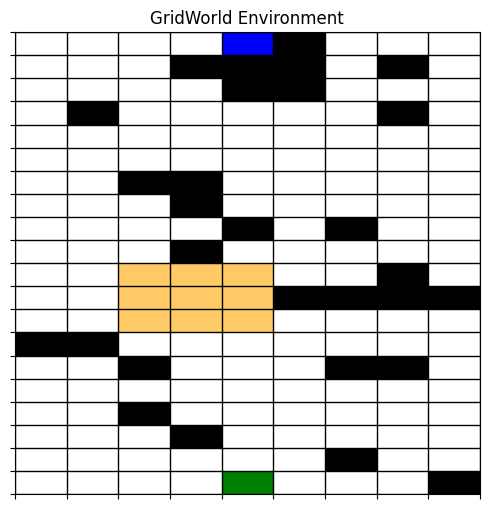


Début de l'entraînement avec curriculum learning...
Groupe d'épisodes 1/50, Complexité: 0.50, 20x9, 15 walls


100%|██████████| 100/100 [00:14<00:00,  6.67it/s]


Moyenne des récompenses: -12.33, Taux de réussite: 6.00%
Nouveau modèle sauvegardé: récompense moyenne = -12.33
Réduction de la complexité à 0.47, 20x9, 13 walls, 1 towers
Groupe d'épisodes 2/50, Complexité: 0.47, 20x9, 13 walls


100%|██████████| 100/100 [00:12<00:00,  7.80it/s]


Moyenne des récompenses: -3.90, Taux de réussite: 71.00%
Nouveau modèle sauvegardé: récompense moyenne = -3.90
Groupe d'épisodes 3/50, Complexité: 0.47, 20x9, 13 walls


100%|██████████| 100/100 [00:13<00:00,  7.66it/s]


Moyenne des récompenses: -1.72, Taux de réussite: 75.00%
Nouveau modèle sauvegardé: récompense moyenne = -1.72
Groupe d'épisodes 4/50, Complexité: 0.47, 20x9, 13 walls


100%|██████████| 100/100 [00:11<00:00,  8.58it/s]


Moyenne des récompenses: 0.33, Taux de réussite: 90.00%
Nouveau modèle sauvegardé: récompense moyenne = 0.33
Augmentation de la complexité à 0.52, 20x9, 15 walls, 2 towers
Groupe d'épisodes 5/50, Complexité: 0.52, 20x9, 15 walls


100%|██████████| 100/100 [00:12<00:00,  8.10it/s]


Moyenne des récompenses: -2.29, Taux de réussite: 92.00%
Augmentation de la complexité à 0.57, 20x9, 17 walls, 3 towers
Groupe d'épisodes 6/50, Complexité: 0.57, 20x9, 17 walls


100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


Moyenne des récompenses: -9.83, Taux de réussite: 91.00%
Augmentation de la complexité à 0.62, 20x9, 19 walls, 4 towers
Groupe d'épisodes 7/50, Complexité: 0.62, 20x9, 19 walls


100%|██████████| 100/100 [00:15<00:00,  6.50it/s]


Moyenne des récompenses: -14.75, Taux de réussite: 82.00%
Augmentation de la complexité à 0.67, 20x9, 21 walls, 5 towers
Groupe d'épisodes 8/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:19<00:00,  5.19it/s]


Moyenne des récompenses: -18.32, Taux de réussite: 64.00%
Groupe d'épisodes 9/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:18<00:00,  5.50it/s]


Moyenne des récompenses: -12.62, Taux de réussite: 72.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 10/50, Complexité: 0.57, 20x9, 15 walls


100%|██████████| 100/100 [00:10<00:00,  9.32it/s]


Moyenne des récompenses: 2.53, Taux de réussite: 93.00%
Nouveau modèle sauvegardé: récompense moyenne = 2.53
Augmentation de la complexité à 0.62, 20x9, 17 walls, 2 towers
Groupe d'épisodes 11/50, Complexité: 0.62, 20x9, 17 walls


100%|██████████| 100/100 [00:12<00:00,  7.77it/s]


Moyenne des récompenses: -1.30, Taux de réussite: 89.00%
Nouveau modèle sauvegardé: récompense moyenne = -1.30
Augmentation de la complexité à 0.67, 20x9, 19 walls, 3 towers
Groupe d'épisodes 12/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


Moyenne des récompenses: -14.25, Taux de réussite: 79.00%
Groupe d'épisodes 13/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:17<00:00,  5.82it/s]


Moyenne des récompenses: -10.75, Taux de réussite: 82.00%
Augmentation de la complexité à 0.72, 20x9, 21 walls, 4 towers
Groupe d'épisodes 14/50, Complexité: 0.72, 20x9, 21 walls


100%|██████████| 100/100 [00:21<00:00,  4.68it/s]


Moyenne des récompenses: -13.51, Taux de réussite: 58.00%
Groupe d'épisodes 15/50, Complexité: 0.72, 20x9, 21 walls


100%|██████████| 100/100 [00:21<00:00,  4.67it/s]


Moyenne des récompenses: -12.04, Taux de réussite: 57.00%
Groupe d'épisodes 16/50, Complexité: 0.72, 20x9, 21 walls


100%|██████████| 100/100 [00:21<00:00,  4.70it/s]


Moyenne des récompenses: -11.91, Taux de réussite: 63.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 17/50, Complexité: 0.62, 20x9, 15 walls


100%|██████████| 100/100 [00:12<00:00,  8.22it/s]


Moyenne des récompenses: -0.67, Taux de réussite: 96.00%
Augmentation de la complexité à 0.67, 20x9, 17 walls, 2 towers
Groupe d'épisodes 18/50, Complexité: 0.67, 20x9, 17 walls


100%|██████████| 100/100 [00:16<00:00,  6.00it/s]


Moyenne des récompenses: -10.52, Taux de réussite: 87.00%
Augmentation de la complexité à 0.72, 20x9, 19 walls, 3 towers
Groupe d'épisodes 19/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:20<00:00,  4.77it/s]


Moyenne des récompenses: -11.64, Taux de réussite: 69.00%
Groupe d'épisodes 20/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:20<00:00,  4.83it/s]


Moyenne des récompenses: -13.42, Taux de réussite: 68.00%
Groupe d'épisodes 21/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:20<00:00,  4.90it/s]


Moyenne des récompenses: -12.26, Taux de réussite: 74.00%
Nouveau modèle sauvegardé: récompense moyenne = -12.26
Groupe d'épisodes 22/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:21<00:00,  4.71it/s]


Moyenne des récompenses: -11.23, Taux de réussite: 80.00%
Groupe d'épisodes 23/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:22<00:00,  4.51it/s]


Moyenne des récompenses: -6.79, Taux de réussite: 76.00%
Groupe d'épisodes 24/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:22<00:00,  4.38it/s]


Moyenne des récompenses: -5.52, Taux de réussite: 73.00%
Groupe d'épisodes 25/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


Moyenne des récompenses: -10.89, Taux de réussite: 72.00%
Groupe d'épisodes 26/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:23<00:00,  4.20it/s]


Moyenne des récompenses: -7.68, Taux de réussite: 78.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 27/50, Complexité: 0.62, 20x9, 15 walls


100%|██████████| 100/100 [00:14<00:00,  6.96it/s]


Moyenne des récompenses: -0.52, Taux de réussite: 95.00%
Augmentation de la complexité à 0.67, 20x9, 17 walls, 2 towers
Groupe d'épisodes 28/50, Complexité: 0.67, 20x9, 17 walls


100%|██████████| 100/100 [00:16<00:00,  5.97it/s]


Moyenne des récompenses: -4.74, Taux de réussite: 91.00%
Augmentation de la complexité à 0.72, 20x9, 19 walls, 3 towers
Groupe d'épisodes 29/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:24<00:00,  4.16it/s]


Moyenne des récompenses: -9.66, Taux de réussite: 70.00%
Groupe d'épisodes 30/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:26<00:00,  3.78it/s]


Moyenne des récompenses: -9.70, Taux de réussite: 64.00%
Groupe d'épisodes 31/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.68it/s]


Moyenne des récompenses: -7.59, Taux de réussite: 63.00%
Nouveau modèle sauvegardé: récompense moyenne = -7.59
Groupe d'épisodes 32/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:26<00:00,  3.72it/s]


Moyenne des récompenses: -9.79, Taux de réussite: 69.00%
Groupe d'épisodes 33/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


Moyenne des récompenses: -8.38, Taux de réussite: 72.00%
Groupe d'épisodes 34/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


Moyenne des récompenses: -5.50, Taux de réussite: 70.00%
Groupe d'épisodes 35/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:26<00:00,  3.76it/s]


Moyenne des récompenses: -3.85, Taux de réussite: 77.00%
Groupe d'épisodes 36/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.57it/s]


Moyenne des récompenses: -6.32, Taux de réussite: 65.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 37/50, Complexité: 0.62, 20x9, 15 walls


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


Moyenne des récompenses: -1.10, Taux de réussite: 92.00%
Augmentation de la complexité à 0.67, 20x9, 17 walls, 2 towers
Groupe d'épisodes 38/50, Complexité: 0.67, 20x9, 17 walls


100%|██████████| 100/100 [00:20<00:00,  4.94it/s]


Moyenne des récompenses: -2.21, Taux de réussite: 89.00%
Augmentation de la complexité à 0.72, 20x9, 19 walls, 3 towers
Groupe d'épisodes 39/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:25<00:00,  3.92it/s]


Moyenne des récompenses: -4.55, Taux de réussite: 76.00%
Groupe d'épisodes 40/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.66it/s]


Moyenne des récompenses: -10.34, Taux de réussite: 72.00%
Groupe d'épisodes 41/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.70it/s]


Moyenne des récompenses: -6.96, Taux de réussite: 70.00%
Nouveau modèle sauvegardé: récompense moyenne = -6.96
Groupe d'épisodes 42/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.63it/s]


Moyenne des récompenses: -5.11, Taux de réussite: 69.00%
Groupe d'épisodes 43/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.59it/s]


Moyenne des récompenses: -8.09, Taux de réussite: 70.00%
Groupe d'épisodes 44/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:28<00:00,  3.56it/s]


Moyenne des récompenses: -4.23, Taux de réussite: 70.00%
Groupe d'épisodes 45/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


Moyenne des récompenses: -6.40, Taux de réussite: 65.00%
Groupe d'épisodes 46/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.65it/s]


Moyenne des récompenses: -6.78, Taux de réussite: 68.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 47/50, Complexité: 0.62, 20x9, 15 walls


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


Moyenne des récompenses: 1.28, Taux de réussite: 94.00%
Augmentation de la complexité à 0.67, 20x9, 17 walls, 2 towers
Groupe d'épisodes 48/50, Complexité: 0.67, 20x9, 17 walls


100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


Moyenne des récompenses: -3.53, Taux de réussite: 91.00%
Augmentation de la complexité à 0.72, 20x9, 19 walls, 3 towers
Groupe d'épisodes 49/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:27<00:00,  3.61it/s]


Moyenne des récompenses: -4.88, Taux de réussite: 67.00%
Groupe d'épisodes 50/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:29<00:00,  3.35it/s]

Moyenne des récompenses: -7.60, Taux de réussite: 64.00%


In [ ]:
if __name__ == "__main__":

    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    
    env_params = {
        'rows': 20,
        'cols': 9,
        'num_walls': 15,
        'tower_penalty': -5.5, 
        'tower_timer': 25,
        'retour':True,
        'broken':False, 
        'tower_destroy_reward':0.0,
        'num_towers':1
    }
    
    sample_env = create_random_env(**env_params)
    state_size = len(sample_env.get_state_representation())
    action_size = 5 
    
    print(f"Taille de l'état: {state_size}, Nombre d'actions: {action_size}")
    print("Exemple d'environnement:")
    visualize_env(sample_env)
    
    agent = DQNAgent(state_size, action_size, hidden_sizes=[128, 128], lr=0.0003)
    
    # Entraînement avec curriculum learning
    print("\nDébut de l'entraînement avec curriculum learning...")
    num_episodes = 5000  
    rewards_history = train_dqn_agent_curriculum(env_params, agent, num_episodes)


Test sur un labyrinthe simple:
Test sur un nouveau labyrinthe 20x9 avec 28 murs:


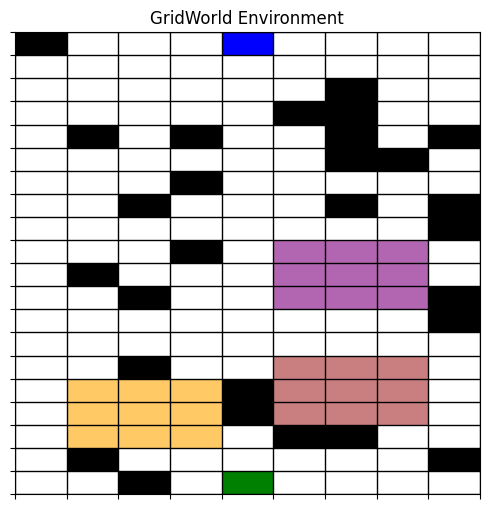

Agent a réussi en 93 pas avec une récompense de 0.35
Moviepy - Building video dqn_maze_20x9.mp4.
Moviepy - Writing video dqn_maze_20x9.mp4



Moviepy - Done !
Moviepy - video ready dqn_maze_20x9.mp4


In [43]:
# Test sur un labyrinthe simple
print("\nTest sur un labyrinthe simple:")
_, _, _, video = test_agent_on_new_maze(agent, rows=20, cols=9, num_walls=10, complexity=1.0, tower_penalty=-5.5, tower_timer=50, num_towers=3, retour=True, seed=2)
video

In [ ]:
export_model_to_onnx(agent, "dqn_tower.onnx")

torch.save({
    'state_dict': agent.policy_net.state_dict(),
    'optimizer': agent.optimizer.state_dict(),
    'state_size': agent.state_size,
    'action_size': agent.action_size,
    'hidden_sizes': [128, 128]
}, "dqn_tower.pt")

Modèle exporté avec succès dans dqn_tower.onnx
Vérification du modèle ONNX réussie!


# IGNORE TOWER

Taille de l'état: 254, Nombre d'actions: 5
Exemple d'environnement:


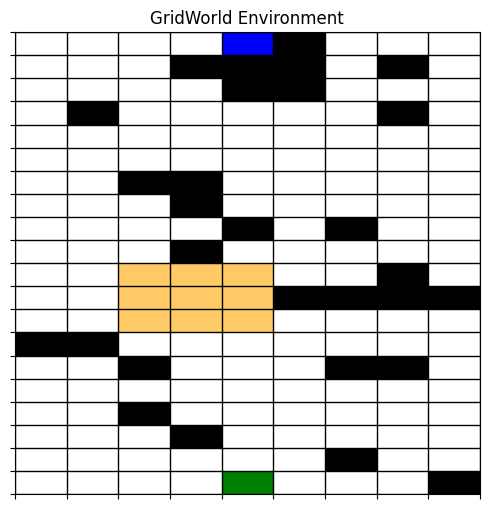


Début de l'entraînement avec curriculum learning...
Groupe d'épisodes 1/50, Complexité: 0.50, 20x9, 15 walls


100%|██████████| 100/100 [00:16<00:00,  6.03it/s]


Moyenne des récompenses: -12.10, Taux de réussite: 1.00%
Nouveau modèle sauvegardé: récompense moyenne = -12.10
Réduction de la complexité à 0.47, 20x9, 13 walls, 1 towers
Groupe d'épisodes 2/50, Complexité: 0.47, 20x9, 13 walls


100%|██████████| 100/100 [00:13<00:00,  7.36it/s]


Moyenne des récompenses: 2.22, Taux de réussite: 70.00%
Nouveau modèle sauvegardé: récompense moyenne = 2.22
Groupe d'épisodes 3/50, Complexité: 0.47, 20x9, 13 walls


100%|██████████| 100/100 [00:09<00:00, 10.15it/s]


Moyenne des récompenses: 6.40, Taux de réussite: 95.00%
Nouveau modèle sauvegardé: récompense moyenne = 6.40
Augmentation de la complexité à 0.52, 20x9, 15 walls, 2 towers
Groupe d'épisodes 4/50, Complexité: 0.52, 20x9, 15 walls


100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


Moyenne des récompenses: 6.42, Taux de réussite: 93.00%
Nouveau modèle sauvegardé: récompense moyenne = 6.42
Augmentation de la complexité à 0.57, 20x9, 17 walls, 3 towers
Groupe d'épisodes 5/50, Complexité: 0.57, 20x9, 17 walls


100%|██████████| 100/100 [00:10<00:00,  9.83it/s]


Moyenne des récompenses: 4.11, Taux de réussite: 85.00%
Augmentation de la complexité à 0.62, 20x9, 19 walls, 4 towers
Groupe d'épisodes 6/50, Complexité: 0.62, 20x9, 19 walls


100%|██████████| 100/100 [00:13<00:00,  7.20it/s]


Moyenne des récompenses: -1.56, Taux de réussite: 65.00%
Groupe d'épisodes 7/50, Complexité: 0.62, 20x9, 19 walls


100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


Moyenne des récompenses: 3.57, Taux de réussite: 81.00%
Augmentation de la complexité à 0.67, 20x9, 21 walls, 5 towers
Groupe d'épisodes 8/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:13<00:00,  7.61it/s]


Moyenne des récompenses: -0.30, Taux de réussite: 70.00%
Groupe d'épisodes 9/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:18<00:00,  5.42it/s]


Moyenne des récompenses: -4.88, Taux de réussite: 40.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 10/50, Complexité: 0.57, 20x9, 15 walls


100%|██████████| 100/100 [00:09<00:00, 10.92it/s]


Moyenne des récompenses: 6.32, Taux de réussite: 91.00%
Augmentation de la complexité à 0.62, 20x9, 17 walls, 2 towers
Groupe d'épisodes 11/50, Complexité: 0.62, 20x9, 17 walls


100%|██████████| 100/100 [00:10<00:00,  9.68it/s]


Moyenne des récompenses: 6.16, Taux de réussite: 89.00%
Nouveau modèle sauvegardé: récompense moyenne = 6.16
Augmentation de la complexité à 0.67, 20x9, 19 walls, 3 towers
Groupe d'épisodes 12/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Moyenne des récompenses: 2.34, Taux de réussite: 74.00%
Groupe d'épisodes 13/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


Moyenne des récompenses: 2.45, Taux de réussite: 74.00%
Groupe d'épisodes 14/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:12<00:00,  8.19it/s]


Moyenne des récompenses: 5.65, Taux de réussite: 83.00%
Augmentation de la complexité à 0.72, 20x9, 21 walls, 4 towers
Groupe d'épisodes 15/50, Complexité: 0.72, 20x9, 21 walls


100%|██████████| 100/100 [00:16<00:00,  6.13it/s]


Moyenne des récompenses: -0.93, Taux de réussite: 63.00%
Groupe d'épisodes 16/50, Complexité: 0.72, 20x9, 21 walls


100%|██████████| 100/100 [00:17<00:00,  5.66it/s]


Moyenne des récompenses: -1.67, Taux de réussite: 61.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 17/50, Complexité: 0.62, 20x9, 15 walls


100%|██████████| 100/100 [00:09<00:00, 10.03it/s]


Moyenne des récompenses: 7.00, Taux de réussite: 94.00%
Nouveau modèle sauvegardé: récompense moyenne = 7.00
Augmentation de la complexité à 0.67, 20x9, 17 walls, 2 towers
Groupe d'épisodes 18/50, Complexité: 0.67, 20x9, 17 walls


100%|██████████| 100/100 [00:10<00:00,  9.73it/s]


Moyenne des récompenses: 7.00, Taux de réussite: 92.00%
Nouveau modèle sauvegardé: récompense moyenne = 7.00
Augmentation de la complexité à 0.72, 20x9, 19 walls, 3 towers
Groupe d'épisodes 19/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  5.90it/s]


Moyenne des récompenses: 1.64, Taux de réussite: 69.00%
Groupe d'épisodes 20/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Moyenne des récompenses: 2.86, Taux de réussite: 75.00%
Groupe d'épisodes 21/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:17<00:00,  5.80it/s]


Moyenne des récompenses: 1.21, Taux de réussite: 67.00%
Nouveau modèle sauvegardé: récompense moyenne = 1.21
Groupe d'épisodes 22/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


Moyenne des récompenses: 1.70, Taux de réussite: 71.00%
Groupe d'épisodes 23/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.34it/s]


Moyenne des récompenses: -0.76, Taux de réussite: 64.00%
Groupe d'épisodes 24/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


Moyenne des récompenses: 0.61, Taux de réussite: 67.00%
Groupe d'épisodes 25/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Moyenne des récompenses: 2.50, Taux de réussite: 72.00%
Groupe d'épisodes 26/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Moyenne des récompenses: 1.80, Taux de réussite: 69.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 27/50, Complexité: 0.62, 20x9, 15 walls


100%|██████████| 100/100 [00:10<00:00,  9.14it/s]


Moyenne des récompenses: 6.69, Taux de réussite: 89.00%
Augmentation de la complexité à 0.67, 20x9, 17 walls, 2 towers
Groupe d'épisodes 28/50, Complexité: 0.67, 20x9, 17 walls


100%|██████████| 100/100 [00:11<00:00,  8.72it/s]


Moyenne des récompenses: 6.60, Taux de réussite: 87.00%
Augmentation de la complexité à 0.72, 20x9, 19 walls, 3 towers
Groupe d'épisodes 29/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  6.16it/s]


Moyenne des récompenses: 2.98, Taux de réussite: 75.00%
Groupe d'épisodes 30/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  5.93it/s]


Moyenne des récompenses: 2.15, Taux de réussite: 68.00%
Groupe d'épisodes 31/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  5.98it/s]


Moyenne des récompenses: 3.10, Taux de réussite: 75.00%
Nouveau modèle sauvegardé: récompense moyenne = 3.10
Groupe d'épisodes 32/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:15<00:00,  6.39it/s]


Moyenne des récompenses: 3.81, Taux de réussite: 77.00%
Groupe d'épisodes 33/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  6.17it/s]


Moyenne des récompenses: 4.32, Taux de réussite: 77.00%
Groupe d'épisodes 34/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:17<00:00,  5.76it/s]


Moyenne des récompenses: 1.97, Taux de réussite: 73.00%
Groupe d'épisodes 35/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Moyenne des récompenses: 2.20, Taux de réussite: 73.00%
Groupe d'épisodes 36/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Moyenne des récompenses: 3.90, Taux de réussite: 76.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 37/50, Complexité: 0.62, 20x9, 15 walls


100%|██████████| 100/100 [00:09<00:00, 10.39it/s]


Moyenne des récompenses: 9.54, Taux de réussite: 97.00%
Nouveau modèle sauvegardé: récompense moyenne = 9.54
Augmentation de la complexité à 0.67, 20x9, 17 walls, 2 towers
Groupe d'épisodes 38/50, Complexité: 0.67, 20x9, 17 walls


100%|██████████| 100/100 [00:12<00:00,  7.88it/s]


Moyenne des récompenses: 6.39, Taux de réussite: 87.00%
Augmentation de la complexité à 0.72, 20x9, 19 walls, 3 towers
Groupe d'épisodes 39/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:17<00:00,  5.57it/s]


Moyenne des récompenses: 1.93, Taux de réussite: 69.00%
Groupe d'épisodes 40/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.49it/s]


Moyenne des récompenses: 1.57, Taux de réussite: 68.00%
Groupe d'épisodes 41/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.40it/s]


Moyenne des récompenses: 1.80, Taux de réussite: 67.00%
Nouveau modèle sauvegardé: récompense moyenne = 1.80
Groupe d'épisodes 42/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.53it/s]


Moyenne des récompenses: 2.33, Taux de réussite: 72.00%
Groupe d'épisodes 43/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:19<00:00,  5.23it/s]


Moyenne des récompenses: 2.18, Taux de réussite: 70.00%
Groupe d'épisodes 44/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:20<00:00,  4.98it/s]


Moyenne des récompenses: 2.00, Taux de réussite: 71.00%
Groupe d'épisodes 45/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.27it/s]


Moyenne des récompenses: 2.08, Taux de réussite: 72.00%
Groupe d'épisodes 46/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Moyenne des récompenses: 5.52, Taux de réussite: 84.00%
Augmentation de la complexité à 0.77, 20x9, 21 walls, 4 towers
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 47/50, Complexité: 0.67, 20x9, 15 walls


100%|██████████| 100/100 [00:10<00:00,  9.58it/s]


Moyenne des récompenses: 7.43, Taux de réussite: 93.00%
Augmentation de la complexité à 0.72, 20x9, 17 walls, 2 towers
Groupe d'épisodes 48/50, Complexité: 0.72, 20x9, 17 walls


100%|██████████| 100/100 [00:13<00:00,  7.17it/s]


Moyenne des récompenses: 6.10, Taux de réussite: 87.00%
Augmentation de la complexité à 0.77, 20x9, 19 walls, 3 towers
Groupe d'épisodes 49/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:20<00:00,  4.82it/s]


Moyenne des récompenses: 1.57, Taux de réussite: 69.00%
Groupe d'épisodes 50/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]

Moyenne des récompenses: 3.37, Taux de réussite: 73.00%


In [ ]:
if __name__ == "__main__":

    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    
    env_params = {
        'rows': 20,
        'cols': 9,
        'num_walls': 15,
        'tower_penalty': -0.0, 
        'tower_timer': 999,
        'retour':False,
        'broken':False, 
        'tower_destroy_reward':0.0,
        'num_towers':1
    }
    
    sample_env = create_random_env(**env_params)
    state_size = len(sample_env.get_state_representation())
    action_size = 5 
    
    print(f"Taille de l'état: {state_size}, Nombre d'actions: {action_size}")
    print("Exemple d'environnement:")
    visualize_env(sample_env)
    
    agent = DQNAgent(state_size, action_size, hidden_sizes=[128, 128], lr=0.0003)
    
    print("\nDébut de l'entraînement avec curriculum learning...")
    num_episodes = 5000 
    rewards_history = train_dqn_agent_curriculum(env_params, agent, num_episodes)


Test sur un labyrinthe simple:
Test sur un nouveau labyrinthe 20x9 avec 42 murs:


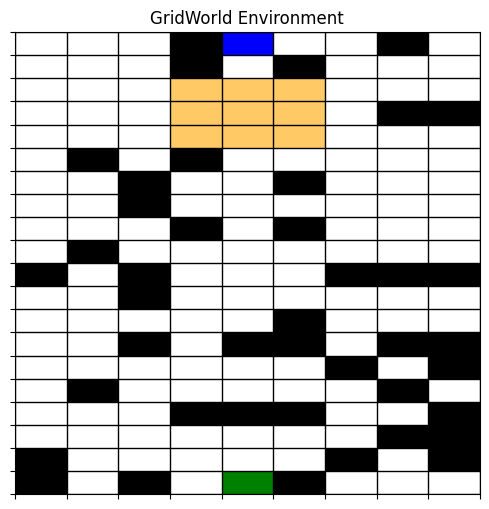

Agent a réussi en 23 pas avec une récompense de 10.74
Moviepy - Building video dqn_maze_20x9.mp4.
Moviepy - Writing video dqn_maze_20x9.mp4



Moviepy - Done !
Moviepy - video ready dqn_maze_20x9.mp4


In [ ]:
print("\nTest sur un labyrinthe simple:")
_, _, _, video = test_agent_on_new_maze(agent, rows=20, cols=9, num_walls=15, complexity=1.0, tower_penalty=-0.0, tower_timer=999, retour=False, seed=55)
video

In [ ]:
export_model_to_onnx(agent, "dqn_base.onnx")

torch.save({
    'state_dict': agent.policy_net.state_dict(),
    'optimizer': agent.optimizer.state_dict(),
    'state_size': agent.state_size,
    'action_size': agent.action_size,
    'hidden_sizes': [128, 128] 
}, "dqn_base.pt")

Modèle exporté avec succès dans dqn_base.onnx
Vérification du modèle ONNX réussie!


# BREAK TOWER

Taille de l'état: 254, Nombre d'actions: 5
Exemple d'environnement:


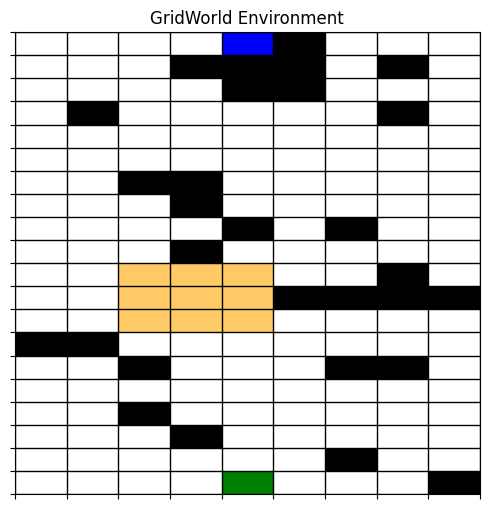


Début de l'entraînement avec curriculum learning...
Groupe d'épisodes 1/50, Complexité: 0.50, 20x9, 15 walls


100%|██████████| 100/100 [00:15<00:00,  6.30it/s]


Moyenne des récompenses: -9.05, Taux de réussite: 5.00%
Nouveau modèle sauvegardé: récompense moyenne = -9.05
Réduction de la complexité à 0.47, 20x9, 13 walls, 1 towers
Groupe d'épisodes 2/50, Complexité: 0.47, 20x9, 13 walls


100%|██████████| 100/100 [00:12<00:00,  7.94it/s]


Moyenne des récompenses: 6.94, Taux de réussite: 82.00%
Nouveau modèle sauvegardé: récompense moyenne = 6.94
Augmentation de la complexité à 0.52, 20x9, 15 walls, 2 towers
Groupe d'épisodes 3/50, Complexité: 0.52, 20x9, 15 walls


100%|██████████| 100/100 [00:11<00:00,  8.70it/s]


Moyenne des récompenses: 9.20, Taux de réussite: 86.00%
Nouveau modèle sauvegardé: récompense moyenne = 9.20
Augmentation de la complexité à 0.57, 20x9, 17 walls, 3 towers
Groupe d'épisodes 4/50, Complexité: 0.57, 20x9, 17 walls


100%|██████████| 100/100 [00:10<00:00,  9.17it/s]


Moyenne des récompenses: 13.33, Taux de réussite: 88.00%
Nouveau modèle sauvegardé: récompense moyenne = 13.33
Augmentation de la complexité à 0.62, 20x9, 19 walls, 4 towers
Groupe d'épisodes 5/50, Complexité: 0.62, 20x9, 19 walls


100%|██████████| 100/100 [00:10<00:00,  9.16it/s]


Moyenne des récompenses: 11.77, Taux de réussite: 79.00%
Groupe d'épisodes 6/50, Complexité: 0.62, 20x9, 19 walls


100%|██████████| 100/100 [00:10<00:00,  9.99it/s]


Moyenne des récompenses: 15.95, Taux de réussite: 89.00%
Nouveau modèle sauvegardé: récompense moyenne = 15.95
Augmentation de la complexité à 0.67, 20x9, 21 walls, 5 towers
Groupe d'épisodes 7/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:11<00:00,  8.54it/s]


Moyenne des récompenses: 13.40, Taux de réussite: 79.00%
Groupe d'épisodes 8/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:12<00:00,  8.00it/s]


Moyenne des récompenses: 11.88, Taux de réussite: 77.00%
Groupe d'épisodes 9/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:12<00:00,  7.87it/s]


Moyenne des récompenses: 9.16, Taux de réussite: 70.00%
Groupe d'épisodes 10/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:13<00:00,  7.57it/s]


Moyenne des récompenses: 10.59, Taux de réussite: 68.00%
Groupe d'épisodes 11/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:14<00:00,  6.84it/s]


Moyenne des récompenses: 11.22, Taux de réussite: 73.00%
Nouveau modèle sauvegardé: récompense moyenne = 11.22
Groupe d'épisodes 12/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:14<00:00,  6.89it/s]


Moyenne des récompenses: 12.03, Taux de réussite: 73.00%
Groupe d'épisodes 13/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:16<00:00,  6.18it/s]


Moyenne des récompenses: 11.30, Taux de réussite: 69.00%
Groupe d'épisodes 14/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:16<00:00,  6.22it/s]


Moyenne des récompenses: 11.20, Taux de réussite: 68.00%
Groupe d'épisodes 15/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:18<00:00,  5.52it/s]


Moyenne des récompenses: 9.95, Taux de réussite: 66.00%
Groupe d'épisodes 16/50, Complexité: 0.67, 20x9, 21 walls


100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Moyenne des récompenses: 11.27, Taux de réussite: 68.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 17/50, Complexité: 0.57, 20x9, 15 walls


100%|██████████| 100/100 [00:09<00:00, 10.88it/s]


Moyenne des récompenses: 11.83, Taux de réussite: 95.00%
Augmentation de la complexité à 0.62, 20x9, 17 walls, 2 towers
Groupe d'épisodes 18/50, Complexité: 0.62, 20x9, 17 walls


100%|██████████| 100/100 [00:10<00:00,  9.85it/s]


Moyenne des récompenses: 15.18, Taux de réussite: 92.00%
Augmentation de la complexité à 0.67, 20x9, 19 walls, 3 towers
Groupe d'épisodes 19/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.51it/s]


Moyenne des récompenses: 9.60, Taux de réussite: 62.00%
Groupe d'épisodes 20/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  6.19it/s]


Moyenne des récompenses: 13.60, Taux de réussite: 72.00%
Groupe d'épisodes 21/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  6.02it/s]


Moyenne des récompenses: 13.81, Taux de réussite: 74.00%
Nouveau modèle sauvegardé: récompense moyenne = 13.81
Groupe d'épisodes 22/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:16<00:00,  6.11it/s]


Moyenne des récompenses: 14.41, Taux de réussite: 77.00%
Groupe d'épisodes 23/50, Complexité: 0.67, 20x9, 19 walls


100%|██████████| 100/100 [00:14<00:00,  7.05it/s]


Moyenne des récompenses: 15.73, Taux de réussite: 84.00%
Augmentation de la complexité à 0.72, 20x9, 21 walls, 4 towers
Groupe d'épisodes 24/50, Complexité: 0.72, 20x9, 21 walls


100%|██████████| 100/100 [00:19<00:00,  5.01it/s]


Moyenne des récompenses: 10.95, Taux de réussite: 67.00%
Groupe d'épisodes 25/50, Complexité: 0.72, 20x9, 21 walls


100%|██████████| 100/100 [00:18<00:00,  5.55it/s]


Moyenne des récompenses: 13.10, Taux de réussite: 75.00%
Groupe d'épisodes 26/50, Complexité: 0.72, 20x9, 21 walls


100%|██████████| 100/100 [00:16<00:00,  6.10it/s]


Moyenne des récompenses: 14.27, Taux de réussite: 79.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 27/50, Complexité: 0.62, 20x9, 15 walls


100%|██████████| 100/100 [00:10<00:00,  9.22it/s]


Moyenne des récompenses: 11.63, Taux de réussite: 95.00%
Augmentation de la complexité à 0.67, 20x9, 17 walls, 2 towers
Groupe d'épisodes 28/50, Complexité: 0.67, 20x9, 17 walls


100%|██████████| 100/100 [00:11<00:00,  8.66it/s]


Moyenne des récompenses: 15.69, Taux de réussite: 93.00%
Augmentation de la complexité à 0.72, 20x9, 19 walls, 3 towers
Groupe d'épisodes 29/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.39it/s]


Moyenne des récompenses: 12.02, Taux de réussite: 69.00%
Groupe d'épisodes 30/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:18<00:00,  5.37it/s]


Moyenne des récompenses: 11.21, Taux de réussite: 70.00%
Groupe d'épisodes 31/50, Complexité: 0.72, 20x9, 19 walls


100%|██████████| 100/100 [00:15<00:00,  6.27it/s]


Moyenne des récompenses: 16.00, Taux de réussite: 82.00%
Nouveau modèle sauvegardé: récompense moyenne = 16.00
Augmentation de la complexité à 0.77, 20x9, 21 walls, 4 towers
Groupe d'épisodes 32/50, Complexité: 0.77, 20x9, 21 walls


100%|██████████| 100/100 [00:20<00:00,  4.80it/s]


Moyenne des récompenses: 10.82, Taux de réussite: 67.00%
Groupe d'épisodes 33/50, Complexité: 0.77, 20x9, 21 walls


100%|██████████| 100/100 [00:22<00:00,  4.40it/s]


Moyenne des récompenses: 9.70, Taux de réussite: 63.00%
Groupe d'épisodes 34/50, Complexité: 0.77, 20x9, 21 walls


100%|██████████| 100/100 [00:23<00:00,  4.17it/s]


Moyenne des récompenses: 8.20, Taux de réussite: 56.00%
Groupe d'épisodes 35/50, Complexité: 0.77, 20x9, 21 walls


100%|██████████| 100/100 [00:23<00:00,  4.19it/s]


Moyenne des récompenses: 10.07, Taux de réussite: 60.00%
Groupe d'épisodes 36/50, Complexité: 0.77, 20x9, 21 walls


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


Moyenne des récompenses: 10.10, Taux de réussite: 65.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 37/50, Complexité: 0.67, 20x9, 15 walls


100%|██████████| 100/100 [00:11<00:00,  8.77it/s]


Moyenne des récompenses: 12.24, Taux de réussite: 97.00%
Augmentation de la complexité à 0.72, 20x9, 17 walls, 2 towers
Groupe d'épisodes 38/50, Complexité: 0.72, 20x9, 17 walls


100%|██████████| 100/100 [00:17<00:00,  5.83it/s]


Moyenne des récompenses: 12.59, Taux de réussite: 82.00%
Augmentation de la complexité à 0.77, 20x9, 19 walls, 3 towers
Groupe d'épisodes 39/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:23<00:00,  4.34it/s]


Moyenne des récompenses: 11.12, Taux de réussite: 64.00%
Groupe d'épisodes 40/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:19<00:00,  5.04it/s]


Moyenne des récompenses: 12.54, Taux de réussite: 74.00%
Groupe d'épisodes 41/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:20<00:00,  4.95it/s]


Moyenne des récompenses: 14.47, Taux de réussite: 76.00%
Nouveau modèle sauvegardé: récompense moyenne = 14.47
Groupe d'épisodes 42/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:21<00:00,  4.65it/s]


Moyenne des récompenses: 12.39, Taux de réussite: 71.00%
Groupe d'épisodes 43/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:19<00:00,  5.06it/s]


Moyenne des récompenses: 13.82, Taux de réussite: 75.00%
Groupe d'épisodes 44/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:20<00:00,  4.85it/s]


Moyenne des récompenses: 14.40, Taux de réussite: 72.00%
Groupe d'épisodes 45/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:20<00:00,  4.79it/s]


Moyenne des récompenses: 11.86, Taux de réussite: 70.00%
Groupe d'épisodes 46/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:20<00:00,  4.84it/s]


Moyenne des récompenses: 13.26, Taux de réussite: 72.00%
Pas d'amélioration depuis 5 groupes. Réinitialisation partielle...
Groupe d'épisodes 47/50, Complexité: 0.67, 20x9, 15 walls


100%|██████████| 100/100 [00:12<00:00,  7.81it/s]


Moyenne des récompenses: 12.17, Taux de réussite: 94.00%
Augmentation de la complexité à 0.72, 20x9, 17 walls, 2 towers
Groupe d'épisodes 48/50, Complexité: 0.72, 20x9, 17 walls


100%|██████████| 100/100 [00:15<00:00,  6.35it/s]


Moyenne des récompenses: 12.72, Taux de réussite: 84.00%
Augmentation de la complexité à 0.77, 20x9, 19 walls, 3 towers
Groupe d'épisodes 49/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:23<00:00,  4.30it/s]


Moyenne des récompenses: 10.33, Taux de réussite: 63.00%
Groupe d'épisodes 50/50, Complexité: 0.77, 20x9, 19 walls


100%|██████████| 100/100 [00:22<00:00,  4.45it/s]

Moyenne des récompenses: 11.07, Taux de réussite: 65.00%


In [ ]:
if __name__ == "__main__":

    np.random.seed(42)
    random.seed(42)
    torch.manual_seed(42)
    
    env_params = {
        'rows': 20,
        'cols': 9,
        'num_walls': 15,
        'tower_penalty': -0.0, 
        'tower_timer': 999,
        'retour':False,
        'broken':True, 
        'tower_destroy_reward':5.5,
        'num_towers':1
    }
    
    sample_env = create_random_env(**env_params)
    state_size = len(sample_env.get_state_representation())
    action_size = 5 
    
    print(f"Taille de l'état: {state_size}, Nombre d'actions: {action_size}")
    print("Exemple d'environnement:")
    visualize_env(sample_env)
    
    agent = DQNAgent(state_size, action_size, hidden_sizes=[128, 128], lr=0.0003)
    
    print("\nDébut de l'entraînement avec curriculum learning...")
    num_episodes = 5000  
    rewards_history = train_dqn_agent_curriculum(env_params, agent, num_episodes)


Test sur un labyrinthe simple:
Test sur un nouveau labyrinthe 20x9 avec 14 murs:


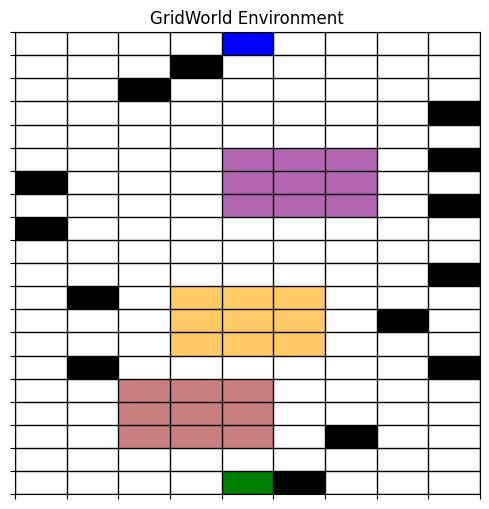

Agent a réussi en 21 pas avec une récompense de 16.23
Moviepy - Building video dqn_maze_20x9.mp4.
Moviepy - Writing video dqn_maze_20x9.mp4



Moviepy - Done !
Moviepy - video ready dqn_maze_20x9.mp4


In [ ]:
print("\nTest sur un labyrinthe simple:")
_, _, _, video = test_agent_on_new_maze(agent, rows=20, cols=9, num_walls=5, complexity=1.0, tower_penalty=-0.0, tower_timer=999, num_towers=3, retour=False, seed=3, broken=True, tower_destroy_reward=5.5)
video

In [ ]:
export_model_to_onnx(agent, "dqn_break.onnx")

torch.save({
    'state_dict': agent.policy_net.state_dict(),
    'optimizer': agent.optimizer.state_dict(),
    'state_size': agent.state_size,
    'action_size': agent.action_size,
    'hidden_sizes': [128, 128]
}, "dqn_break.pt")

Modèle exporté avec succès dans dqn_break.onnx
Vérification du modèle ONNX réussie!
